In [406]:
import json
import pandas as pd
import numpy as np
import spotipy
import requests
import spotipy.util as util
from spotipy.oauth2 import SpotifyOAuth
import os
from collections import defaultdict


In [407]:
%load_ext dotenv
%dotenv

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [408]:

username = os.environ.get("USERNAME")
client_id = os.environ.get("CLIENT_ID")
client_secret = os.environ.get("CLIENT_SECRET")
redirect_uri = 'http://localhost:7777/callback'
scope = 'user-read-recently-played'
data_path = f"./{username}_data"
prefix = f"{username}_"

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id,
                                                client_secret,     
                                                scope=scope, 
                                                redirect_uri=redirect_uri,
                                                username=username))

In [409]:
identifiers_string = open(f"{data_path}/{prefix}Identifiers.json", "r").read()
identifiers_json = json.loads(identifiers_string)

inferences_string = open(f"{data_path}/{prefix}Inferences.json", "r").read()
inferences_json = json.loads(inferences_string)

marquee_string = open(f"{data_path}/{prefix}Marquee.json", "r").read()
marquee_json = json.loads(marquee_string)

playlist_string = open(f"{data_path}/{prefix}Playlist1.json", "r").read()
playlist_json = json.loads(playlist_string)

search_string = open(f"{data_path}/{prefix}SearchQueries.json", "r").read()
search_json = json.loads(search_string)

library_string = open(f"{data_path}/{prefix}YourLibrary.json", "r").read()
library_json = json.loads(library_string)

In [410]:
import ast
from typing import List
from os import listdir
def get_streamings(path: str) -> List[dict]:
    
    files = [f"{data_path}/{x}" for x in listdir(path)
             if x.split('.')[0][:-1] == prefix+'StreamingHistory']
    
    all_streamings = []
    
    for file in files: 
        with open(file, 'r', encoding='UTF-8') as f:
            new_streamings = ast.literal_eval(f.read())
            all_streamings += [streaming for streaming 
                               in new_streamings]
    return all_streamings

In [411]:
# from collections import defaultdict

# streamings = get_streamings(data_path)

# exceptions = 0
# tracks_to_ids = defaultdict()
# for i in range(len(streamings)):
#    track_name = streamings[i]['trackName']
#    if track_name in tracks_to_ids:
#       streamings[i]['id'] = tracks_to_ids[track_name]
#    else:
#       search = sp.search(q=f"track:{track_name}",type="track")
#       try:
#          id = search['tracks']['items'][0]['id']
#          streamings[i]['id'] = id
#       except: #          tracks_to_ids[track_name] = None

# with open(f'{data_path}/{prefix}history_with_ids', 'w') as f:
#    f.write(json.dumps(streamings, indent=2))
#
# nones = 0
# for x, y in tracks_to_ids.items():
#      if y == None:
#         nones+=1

# print(nones)

In [412]:
tracks_file = open(f'{data_path}/{prefix}history_with_ids', 'r')
tracks = json.load(tracks_file)
# drop any rows without an id
indices_to_remove = []
for i in range(len(tracks)):
   try:
      tracks[i]['id']
   except KeyError:
      indices_to_remove.append(i)
      print(tracks[i])

tracks_result = []
prev = 0
for x in indices_to_remove:
   tracks_result += tracks[prev + 1: x]
   prev = x
tracks_clean = tracks_result

{'endTime': '2021-08-17 22:55', 'artistName': 'LILHUDDY', 'trackName': "Don't Freak Out (feat. iann dior, Tyson Ritter & Travis Barker)", 'msPlayed': 156000}
{'endTime': '2021-08-27 02:13', 'artistName': 'Derek Pope', 'trackName': "Don't Make Me Feel Alone", 'msPlayed': 211099}
{'endTime': '2021-08-30 07:19', 'artistName': 'Foals', 'trackName': "I'm Done With The World (& It's Done With Me)", 'msPlayed': 182030}
{'endTime': '2021-09-02 16:36', 'artistName': 'Murge', 'trackName': "Can't Hurt Me Now", 'msPlayed': 359572}
{'endTime': '2021-09-03 01:27', 'artistName': 'James Blake', 'trackName': "Can't Believe The Way We Flow", 'msPlayed': 267200}
{'endTime': '2021-09-03 02:19', 'artistName': 'John Rzeznik', 'trackName': 'I\'m Still Here (Jim\'s Theme) - From "Treasure Planet"/Soundtrack Version', 'msPlayed': 251466}
{'endTime': '2021-09-10 01:04', 'artistName': 'The Tiny Meat Gang Podcast', 'trackName': 'Ep 202 - Cody got a haircut ft. Ben Cahn and Emil DeRosa', 'msPlayed': 847760}
{'endT

In [413]:
tracks_df = pd.DataFrame(tracks).dropna(subset=["id"], axis=0)
unique_ids = tracks_df['id'].unique()
block = 0
features = []
while(len(unique_ids) - block > 0):
   ids = unique_ids[block:block + 100]
   block+=100
   features += sp.audio_features(ids)

In [414]:

features = temp = np.array(features)
features = list(temp[~pd.isna(temp)])

In [415]:
# AFTER RUNNING THE TWO QUERIES THIS SHOULD BE THE FINAL FILE WITH SONG IDS AND FEATURES OF EACH
pd.merge(tracks_df, pd.DataFrame(features), on='id', how='left').to_csv(f'{data_path}/{prefix}history_with_features', index=False)
dataset_detailed_df = pd.read_csv(f'{data_path}/{prefix}history_with_features')


In [416]:
dataset_detailed_df

,endTime,artistName,trackName,msPlayed,id,danceability,energy,key,loudness,mode,...,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
0,2021-08-17 22:43,Trippie Redd,LEADERS,160993,4D7NrSeqkTarBrJ80b2sBc,0.950,0.654,0.0,-5.895,0.0,...,0.000000,0.1380,0.886,132.936,audio_features,spotify:track:4D7NrSeqkTarBrJ80b2sBc,https://api.spotify.com/v1/tracks/4D7NrSeqkTar...,https://api.spotify.com/v1/audio-analysis/4D7N...,194844.0,4.0
1,2021-08-17 22:47,Trippie Redd,FROZEN OCEAN,196169,5ypQ8scn8g2l0341ErES0B,0.314,0.762,2.0,-3.136,1.0,...,0.000022,0.1160,0.310,134.582,audio_features,spotify:track:5ypQ8scn8g2l0341ErES0B,https://api.spotify.com/v1/tracks/5ypQ8scn8g2l...,https://api.spotify.com/v1/audio-analysis/5ypQ...,204233.0,4.0
2,2021-08-17 22:49,WILLOW,t r a n s p a r e n t s o u l feat. Travis Barker,168398,1QL7nSDZCwZMnbisV4KOXt,0.390,0.830,11.0,-5.201,0.0,...,0.000000,0.1560,0.191,90.021,audio_features,spotify:track:1QL7nSDZCwZMnbisV4KOXt,https://api.spotify.com/v1/tracks/1QL7nSDZCwZM...,https://api.spotify.com/v1/audio-analysis/1QL7...,168030.0,4.0
3,2021-08-17 22:52,Machine Gun Kelly,I Think I'm OKAY (with YUNGBLUD & Travis Barker),169397,2gTdDMpNxIRFSiu7HutMCg,0.628,0.744,7.0,-4.718,1.0,...,0.000000,0.3130,0.277,119.921,audio_features,spotify:track:2gTdDMpNxIRFSiu7HutMCg,https://api.spotify.com/v1/tracks/2gTdDMpNxIRF...,https://api.spotify.com/v1/audio-analysis/2gTd...,169397.0,4.0
4,2021-08-17 22:58,Trippie Redd,PILL BREAKER (feat. blackbear & Machine Gun Ke...,177058,7jjnn6K7p5MgOFuqLypAcM,0.527,0.790,2.0,-6.268,1.0,...,0.000000,0.3700,0.236,153.034,audio_features,spotify:track:7jjnn6K7p5MgOFuqLypAcM,https://api.spotify.com/v1/tracks/7jjnn6K7p5Mg...,https://api.spotify.com/v1/audio-analysis/7jjn...,177059.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12658,2021-08-17 22:29,Trippie Redd,RED SKY (feat. Machine Gun Kelly),152149,0yFfjXtSDkr81WVAPPS1Q4,0.472,0.769,7.0,-4.198,1.0,...,0.000000,0.2390,0.587,159.999,audio_features,spotify:track:0yFfjXtSDkr81WVAPPS1Q4,https://api.spotify.com/v1/tracks/0yFfjXtSDkr8...,https://api.spotify.com/v1/audio-analysis/0yFf...,152149.0,4.0
12659,2021-08-17 22:33,Trippie Redd,MEGLADON,194992,5Kq6LIFZsVD99rb7iT0QTG,0.453,0.739,7.0,-4.977,1.0,...,0.000000,0.6940,0.258,139.962,audio_features,spotify:track:5Kq6LIFZsVD99rb7iT0QTG,https://api.spotify.com/v1/tracks/5Kq6LIFZsVD9...,https://api.spotify.com/v1/audio-analysis/5Kq6...,194992.0,4.0
12660,2021-08-17 22:35,Trippie Redd,SAVE YOURSELF,160729,6FhB5ZyT4JsIJ0ozDlXCIp,0.503,0.921,8.0,-5.907,0.0,...,0.000003,0.2600,0.359,121.983,audio_features,spotify:track:6FhB5ZyT4JsIJ0ozDlXCIp,https://api.spotify.com/v1/tracks/6FhB5ZyT4JsI...,https://api.spotify.com/v1/audio-analysis/6FhB...,221160.0,4.0
12661,2021-08-17 22:38,Trippie Redd,DREAMER,170000,4yZEX3NsnXfobmZ0m8ZO4Y,0.723,0.751,9.0,-5.233,0.0,...,0.000000,0.0680,0.642,126.999,audio_features,spotify:track:4yZEX3NsnXfobmZ0m8ZO4Y,https://api.spotify.com/v1/tracks/4yZEX3NsnXfo...,https://api.spotify.com/v1/audio-analysis/4yZE...,190849.0,4.0


In [417]:
# normalizing loudness and tempo
from sklearn import preprocessing

loudness = dataset_detailed_df[['loudness']].values
min_max_scaler = preprocessing.MinMaxScaler()
loudness_scaled = min_max_scaler.fit_transform(loudness)
dataset_detailed_df['loudness'] = loudness_scaled
dataset_detailed_df

tempo = dataset_detailed_df[['tempo']].values
min_max_scaler = preprocessing.MinMaxScaler()
tempo_scaled = min_max_scaler.fit_transform(tempo)
dataset_detailed_df['tempo'] = tempo_scaled
dataset_detailed_df

,endTime,artistName,trackName,msPlayed,id,danceability,energy,key,loudness,mode,...,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
0,2021-08-17 22:43,Trippie Redd,LEADERS,160993,4D7NrSeqkTarBrJ80b2sBc,0.950,0.654,0.0,0.870518,0.0,...,0.000000,0.1380,0.886,0.616847,audio_features,spotify:track:4D7NrSeqkTarBrJ80b2sBc,https://api.spotify.com/v1/tracks/4D7NrSeqkTar...,https://api.spotify.com/v1/audio-analysis/4D7N...,194844.0,4.0
1,2021-08-17 22:47,Trippie Redd,FROZEN OCEAN,196169,5ypQ8scn8g2l0341ErES0B,0.314,0.762,2.0,0.935684,1.0,...,0.000022,0.1160,0.310,0.624484,audio_features,spotify:track:5ypQ8scn8g2l0341ErES0B,https://api.spotify.com/v1/tracks/5ypQ8scn8g2l...,https://api.spotify.com/v1/audio-analysis/5ypQ...,204233.0,4.0
2,2021-08-17 22:49,WILLOW,t r a n s p a r e n t s o u l feat. Travis Barker,168398,1QL7nSDZCwZMnbisV4KOXt,0.390,0.830,11.0,0.886910,0.0,...,0.000000,0.1560,0.191,0.417713,audio_features,spotify:track:1QL7nSDZCwZMnbisV4KOXt,https://api.spotify.com/v1/tracks/1QL7nSDZCwZM...,https://api.spotify.com/v1/audio-analysis/1QL7...,168030.0,4.0
3,2021-08-17 22:52,Machine Gun Kelly,I Think I'm OKAY (with YUNGBLUD & Travis Barker),169397,2gTdDMpNxIRFSiu7HutMCg,0.628,0.744,7.0,0.898318,1.0,...,0.000000,0.3130,0.277,0.556455,audio_features,spotify:track:2gTdDMpNxIRFSiu7HutMCg,https://api.spotify.com/v1/tracks/2gTdDMpNxIRF...,https://api.spotify.com/v1/audio-analysis/2gTd...,169397.0,4.0
4,2021-08-17 22:58,Trippie Redd,PILL BREAKER (feat. blackbear & Machine Gun Ke...,177058,7jjnn6K7p5MgOFuqLypAcM,0.527,0.790,2.0,0.861708,1.0,...,0.000000,0.3700,0.236,0.710105,audio_features,spotify:track:7jjnn6K7p5MgOFuqLypAcM,https://api.spotify.com/v1/tracks/7jjnn6K7p5Mg...,https://api.spotify.com/v1/audio-analysis/7jjn...,177059.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12658,2021-08-17 22:29,Trippie Redd,RED SKY (feat. Machine Gun Kelly),152149,0yFfjXtSDkr81WVAPPS1Q4,0.472,0.769,7.0,0.910600,1.0,...,0.000000,0.2390,0.587,0.742424,audio_features,spotify:track:0yFfjXtSDkr81WVAPPS1Q4,https://api.spotify.com/v1/tracks/0yFfjXtSDkr8...,https://api.spotify.com/v1/audio-analysis/0yFf...,152149.0,4.0
12659,2021-08-17 22:33,Trippie Redd,MEGLADON,194992,5Kq6LIFZsVD99rb7iT0QTG,0.453,0.739,7.0,0.892201,1.0,...,0.000000,0.6940,0.258,0.649449,audio_features,spotify:track:5Kq6LIFZsVD99rb7iT0QTG,https://api.spotify.com/v1/tracks/5Kq6LIFZsVD9...,https://api.spotify.com/v1/audio-analysis/5Kq6...,194992.0,4.0
12660,2021-08-17 22:35,Trippie Redd,SAVE YOURSELF,160729,6FhB5ZyT4JsIJ0ozDlXCIp,0.503,0.921,8.0,0.870235,0.0,...,0.000003,0.2600,0.359,0.566023,audio_features,spotify:track:6FhB5ZyT4JsIJ0ozDlXCIp,https://api.spotify.com/v1/tracks/6FhB5ZyT4JsI...,https://api.spotify.com/v1/audio-analysis/6FhB...,221160.0,4.0
12661,2021-08-17 22:38,Trippie Redd,DREAMER,170000,4yZEX3NsnXfobmZ0m8ZO4Y,0.723,0.751,9.0,0.886154,0.0,...,0.000000,0.0680,0.642,0.589298,audio_features,spotify:track:4yZEX3NsnXfobmZ0m8ZO4Y,https://api.spotify.com/v1/tracks/4yZEX3NsnXfo...,https://api.spotify.com/v1/audio-analysis/4yZE...,190849.0,4.0


In [418]:
# format for kmenas, dropping non-numerical

dataset_detailed_df = dataset_detailed_df.dropna()
dataset_df = dataset_detailed_df.drop(['endTime', 'artistName', 'trackName', 'msPlayed', 'id', 'key', 'mode', 'type', 'uri', 'track_href', 'analysis_url', 'duration_ms', 'time_signature', 'instrumentalness'], axis=1)
dataset_df

,danceability,energy,loudness,speechiness,acousticness,liveness,valence,tempo
0,0.950,0.654,0.870518,0.3070,0.07440,0.1380,0.886,0.616847
1,0.314,0.762,0.935684,0.0356,0.00429,0.1160,0.310,0.624484
2,0.390,0.830,0.886910,0.0563,0.00210,0.1560,0.191,0.417713
3,0.628,0.744,0.898318,0.0379,0.02570,0.3130,0.277,0.556455
4,0.527,0.790,0.861708,0.0788,0.01600,0.3700,0.236,0.710105
...,...,...,...,...,...,...,...,...
12658,0.472,0.769,0.910600,0.0419,0.02490,0.2390,0.587,0.742424
12659,0.453,0.739,0.892201,0.0515,0.00426,0.6940,0.258,0.649449
12660,0.503,0.921,0.870235,0.1060,0.00093,0.2600,0.359,0.566023
12661,0.723,0.751,0.886154,0.0450,0.41200,0.0680,0.642,0.589298


In [419]:
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(dataset_df)
    Sum_of_squared_distances.append(km.inertia_)

In [420]:


from sklearn.metrics import silhouette_score
for n_clusters in range(2,15):
    clusterer = KMeans (n_clusters=n_clusters)
    preds = clusterer.fit_predict(dataset_df)
    centers = clusterer.cluster_centers_

    score = silhouette_score (dataset_df, preds, metric='euclidean')



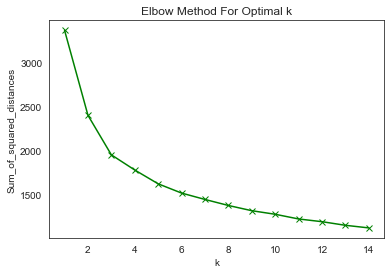

In [421]:
# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(K, Sum_of_squared_distances, 'gx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [422]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(dataset_df)

KMeans(n_clusters=5)

In [423]:
from sklearn.decomposition import PCA
y_kmeans = kmeans.predict(dataset_df)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(dataset_df)

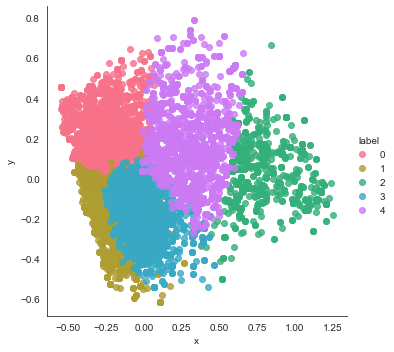

In [424]:
import seaborn as sns
#set style of plots
sns.set_style('white')

#define a custom palette

pc = pd.DataFrame(principal_components)
pc['label'] = y_kmeans
pc.columns = ['x', 'y','label']

#plot data with seaborn
cluster = sns.lmplot(data=pc, x='x', y='y', hue='label', 
                   fit_reg=False)

In [425]:
from sklearn.manifold import TSNE #T-Distributed Stochastic Neighbor Embedding
#T-SNE with two dimensions
tsne = TSNE(n_components=2, perplexity=50)

tsne_components = tsne.fit_transform(dataset_df)

/Users/mcuento/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/mcuento/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


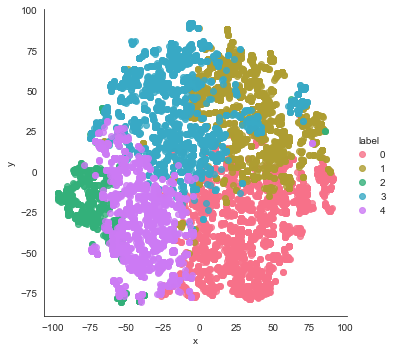

In [426]:
ts = pd.DataFrame(tsne_components)
ts['label'] = y_kmeans
ts.columns = ['x', 'y','label']

#plot data with seaborn
cluster = sns.lmplot(data=ts, x='x', y='y', hue='label', 
                   fit_reg=False, legend=True)



In [427]:
print(pd.DataFrame(pca.components_,columns=dataset_df.columns,index = ['PC-1','PC-2']))

      danceability    energy  loudness  speechiness  acousticness  liveness  \
PC-1     -0.143128 -0.494645 -0.203839    -0.033720      0.742103 -0.055899   
PC-2      0.303127 -0.082120 -0.014507     0.085208      0.418193  0.006998   

       valence     tempo  
PC-1 -0.362872 -0.081458  
PC-2  0.847903 -0.005032  


In [428]:
dataset_detailed_df['label'] = y_kmeans

dataset_detailed_df = dataset_detailed_df.sample(frac=1)
dataset_detailed_df['label'].value_counts()

/var/folders/xy/7p54kpbs7f16djjx60_rtvch0000gn/T/ipykernel_82294/2896304468.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_detailed_df['label'] = y_kmeans


0    3544
3    3244
1    2596
4    2350
2     926
Name: label, dtype: int64

In [429]:
dataset_detailed_df[dataset_detailed_df['label'] == 1].mean()

/var/folders/xy/7p54kpbs7f16djjx60_rtvch0000gn/T/ipykernel_82294/1919225646.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dataset_detailed_df[dataset_detailed_df['label'] == 1].mean()


msPlayed            184813.298536
danceability             0.495315
energy                   0.823888
key                      5.392527
loudness                 0.877631
mode                     0.649076
speechiness              0.112979
acousticness             0.053670
instrumentalness         0.147714
liveness                 0.235107
valence                  0.339501
tempo                    0.628960
duration_ms         237859.816641
time_signature           3.916025
label                    1.000000
dtype: float64

In [430]:
dataset_detailed_df[dataset_detailed_df['label'] == 0].mean()

/var/folders/xy/7p54kpbs7f16djjx60_rtvch0000gn/T/ipykernel_82294/3217743555.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dataset_detailed_df[dataset_detailed_df['label'] == 0].mean()


msPlayed            163853.051919
danceability             0.700338
energy                   0.717879
key                      5.638826
loudness                 0.859092
mode                     0.604402
speechiness              0.124307
acousticness             0.114000
instrumentalness         0.072822
liveness                 0.201203
valence                  0.715670
tempo                    0.558047
duration_ms         204898.521727
time_signature           4.005079
label                    0.000000
dtype: float64

In [431]:
dataset_detailed_df[dataset_detailed_df['label'] == 4].mean()

/var/folders/xy/7p54kpbs7f16djjx60_rtvch0000gn/T/ipykernel_82294/414142442.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dataset_detailed_df[dataset_detailed_df['label'] == 4].mean()


msPlayed            169532.515745
danceability             0.642607
energy                   0.525898
key                      4.804255
loudness                 0.800087
mode                     0.637447
speechiness              0.118273
acousticness             0.561570
instrumentalness         0.112883
liveness                 0.186156
valence                  0.438600
tempo                    0.539125
duration_ms         211281.122979
time_signature           3.925106
label                    4.000000
dtype: float64

In [432]:
dataset_detailed_df[dataset_detailed_df['label'] == 3].mean()

/var/folders/xy/7p54kpbs7f16djjx60_rtvch0000gn/T/ipykernel_82294/1652320848.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dataset_detailed_df[dataset_detailed_df['label'] == 3].mean()


msPlayed            178269.493218
danceability             0.636874
energy                   0.558662
key                      4.939889
loudness                 0.820826
mode                     0.613440
speechiness              0.079188
acousticness             0.103201
instrumentalness         0.139596
liveness                 0.158543
valence                  0.247831
tempo                    0.516125
duration_ms         234293.381936
time_signature           3.954069
label                    3.000000
dtype: float64

In [433]:
dataset_detailed_df[dataset_detailed_df['label'] == 2].mean()

/var/folders/xy/7p54kpbs7f16djjx60_rtvch0000gn/T/ipykernel_82294/536363168.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dataset_detailed_df[dataset_detailed_df['label'] == 2].mean()


msPlayed            170874.413607
danceability             0.413739
energy                   0.240882
key                      5.236501
loudness                 0.628401
mode                     0.724622
speechiness              0.072987
acousticness             0.835681
instrumentalness         0.405860
liveness                 0.172142
valence                  0.186455
tempo                    0.509769
duration_ms         203786.979482
time_signature           3.768898
label                    2.000000
dtype: float64

In [434]:
dataset_detailed_df[dataset_detailed_df['label'] == 0].tail(50) #rhythmic, dance

,endTime,artistName,trackName,msPlayed,id,danceability,energy,key,loudness,mode,...,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,label
9521,2021-05-08 22:43,The Game,The Game & Skrillex: El Chapo,220078,1bW6HUcNcEP9LCuq694yeE,0.754,0.909,6.0,0.931267,0.0,...,0.2810,0.591,0.589275,audio_features,spotify:track:1bW6HUcNcEP9LCuq694yeE,https://api.spotify.com/v1/tracks/1bW6HUcNcEP9...,https://api.spotify.com/v1/audio-analysis/1bW6...,220079.0,4.0,0
11431,2021-07-20 15:24,The Doors,Break on Through (To the Other Side),1632,6ToM0uwxtPKo9CMpbPGYvM,0.421,0.751,9.0,0.783386,1.0,...,0.1700,0.789,0.416869,audio_features,spotify:track:6ToM0uwxtPKo9CMpbPGYvM,https://api.spotify.com/v1/tracks/6ToM0uwxtPKo...,https://api.spotify.com/v1/audio-analysis/6ToM...,145867.0,4.0,0
12141,2021-08-05 18:56,Isaiah Rashad,Headshots (4r Da Locals),14512,0xta6Gah3inmeHbj0e3F9a,0.894,0.615,3.0,0.861685,1.0,...,0.3090,0.661,0.556821,audio_features,spotify:track:0xta6Gah3inmeHbj0e3F9a,https://api.spotify.com/v1/tracks/0xta6Gah3inm...,https://api.spotify.com/v1/audio-analysis/0xta...,193209.0,4.0,0
11145,2021-07-13 00:49,Dugong Jr,Holding On,180582,6CN7FuZ7o1xle9TNxApGeQ,0.706,0.760,8.0,0.898696,1.0,...,0.2020,0.564,0.443132,audio_features,spotify:track:6CN7FuZ7o1xle9TNxApGeQ,https://api.spotify.com/v1/tracks/6CN7FuZ7o1xl...,https://api.spotify.com/v1/audio-analysis/6CN7...,126444.0,4.0,0
3585,2020-11-27 18:04,Oddisee,Ready To Rock,249951,5gTvQeSZbSFJdh7dxF71e0,0.836,0.757,5.0,0.864070,1.0,...,0.0812,0.907,0.496504,audio_features,spotify:track:5gTvQeSZbSFJdh7dxF71e0,https://api.spotify.com/v1/tracks/5gTvQeSZbSFJ...,https://api.spotify.com/v1/audio-analysis/5gTv...,196196.0,4.0,0
8471,2021-03-17 19:41,KAYTRANADA,Puff Lah,113346,21mimz3pv3JD4r8wEJJfNg,0.707,0.863,11.0,0.833341,1.0,...,0.2360,0.735,0.501241,audio_features,spotify:track:21mimz3pv3JD4r8wEJJfNg,https://api.spotify.com/v1/tracks/21mimz3pv3JD...,https://api.spotify.com/v1/audio-analysis/21mi...,113347.0,4.0,0
4768,2020-12-20 01:04,Kid Cudi,Brothers,18366,4qu63nuBpdn0qHUHuObEj1,0.721,0.738,7.0,0.897090,1.0,...,0.1180,0.637,0.556710,audio_features,spotify:track:4qu63nuBpdn0qHUHuObEj1,https://api.spotify.com/v1/tracks/4qu63nuBpdn0...,https://api.spotify.com/v1/audio-analysis/4qu6...,154983.0,4.0,0
1393,2021-09-20 22:50,kerri,GROWING PAINS,214426,6B3VHoemogRyAp6VokPNKF,0.626,0.946,1.0,0.900066,0.0,...,0.1490,0.679,0.477957,audio_features,spotify:track:6B3VHoemogRyAp6VokPNKF,https://api.spotify.com/v1/tracks/6B3VHoemogRy...,https://api.spotify.com/v1/audio-analysis/6B3V...,211533.0,4.0,0
1170,2021-09-14 16:34,kerri,GROWING PAINS,83182,6B3VHoemogRyAp6VokPNKF,0.626,0.946,1.0,0.900066,0.0,...,0.1490,0.679,0.477957,audio_features,spotify:track:6B3VHoemogRyAp6VokPNKF,https://api.spotify.com/v1/tracks/6B3VHoemogRy...,https://api.spotify.com/v1/audio-analysis/6B3V...,211533.0,4.0,0
8872,2021-03-30 20:20,Mike Irish,Grandfather Clocks,247000,5VKM9nypPJrkFlhfgRxJSj,0.439,0.671,5.0,0.877935,0.0,...,0.2820,0.686,0.318725,audio_features,spotify:track:5VKM9nypPJrkFlhfgRxJSj,https://api.spotify.com/v1/tracks/5VKM9nypPJrk...,https://api.spotify.com/v1/audio-analysis/5VKM...,247000.0,4.0,0


In [435]:
dataset_detailed_df[dataset_detailed_df['label'] == 1].tail(50) #serious

,endTime,artistName,trackName,msPlayed,id,danceability,energy,key,loudness,mode,...,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,label
9709,2021-05-14 20:00,The Kid LAROI,FEEL SOMETHING (feat. Marshmello),94532,1yP6g2Ka4CisR3i2cuIcjK,0.523,0.609,1.0,0.825476,1.0,...,0.1400,0.3740,0.714824,audio_features,spotify:track:1yP6g2Ka4CisR3i2cuIcjK,https://api.spotify.com/v1/tracks/1yP6g2Ka4Cis...,https://api.spotify.com/v1/audio-analysis/1yP6...,139041.0,4.0,1
11325,2021-07-17 00:14,Juelz,Colours,17336,6gSKswfcoWvaadqvuMF3Y7,0.529,0.830,6.0,0.881548,1.0,...,0.0983,0.3180,0.435866,audio_features,spotify:track:6gSKswfcoWvaadqvuMF3Y7,https://api.spotify.com/v1/tracks/6gSKswfcoWva...,https://api.spotify.com/v1/audio-analysis/6gSK...,257787.0,4.0,1
3124,2020-11-17 03:24,George Clanton,Crash Pad,259448,7tkrANwXJBcuOaZoGV4Eyn,0.600,0.915,2.0,0.910270,1.0,...,0.1280,0.4940,0.408326,audio_features,spotify:track:7tkrANwXJBcuOaZoGV4Eyn,https://api.spotify.com/v1/tracks/7tkrANwXJBcu...,https://api.spotify.com/v1/audio-analysis/7tkr...,259448.0,4.0,1
2844,2020-11-08 01:51,Jean Dawson,Starface*,176099,6HtBewFr9pHwVbz07oLU9O,0.468,0.934,9.0,0.926945,1.0,...,0.3040,0.5910,0.403793,audio_features,spotify:track:6HtBewFr9pHwVbz07oLU9O,https://api.spotify.com/v1/tracks/6HtBewFr9pHw...,https://api.spotify.com/v1/audio-analysis/6HtB...,176100.0,4.0,1
4406,2020-12-14 17:13,Mac Miller,Two Matches (feat. Ab-Soul),276386,5dhYmSVGhAVVSf5uTwj7hv,0.622,0.873,2.0,0.891776,1.0,...,0.5720,0.4920,0.369892,audio_features,spotify:track:5dhYmSVGhAVVSf5uTwj7hv,https://api.spotify.com/v1/tracks/5dhYmSVGhAVV...,https://api.spotify.com/v1/audio-analysis/5dhY...,276387.0,4.0,1
949,2021-09-09 17:45,Paris Shadows,CRUSHIN (feat. Travis Barker),197546,1eElPFf9odWZwk2i0Ko8xB,0.498,0.885,7.0,0.900255,0.0,...,0.2450,0.3580,0.603205,audio_features,spotify:track:1eElPFf9odWZwk2i0Ko8xB,https://api.spotify.com/v1/tracks/1eElPFf9odWZ...,https://api.spotify.com/v1/audio-analysis/1eEl...,197547.0,4.0,1
11100,2021-07-11 16:16,The Kid LAROI,STAY (with Justin Bieber),49258,5HCyWlXZPP0y6Gqq8TgA20,0.591,0.764,1.0,0.880226,1.0,...,0.1030,0.4780,0.788496,audio_features,spotify:track:5HCyWlXZPP0y6Gqq8TgA20,https://api.spotify.com/v1/tracks/5HCyWlXZPP0y...,https://api.spotify.com/v1/audio-analysis/5HCy...,141806.0,4.0,1
11794,2021-07-27 13:57,MØ,Final Song - Diplo & Jauz Remix,320138,0gahmokctHhYjyR3ZUGr7L,0.687,0.843,9.0,0.939511,1.0,...,0.0751,0.3440,0.584718,audio_features,spotify:track:0gahmokctHhYjyR3ZUGr7L,https://api.spotify.com/v1/tracks/0gahmokctHhY...,https://api.spotify.com/v1/audio-analysis/0gah...,190480.0,4.0,1
12362,2021-08-13 01:43,Keys N Krates,Glitter (feat. Ambré Perkins) - Netsky Remix,173793,1BXBAmb1lGgPg9nFy4bIdT,0.426,0.676,8.0,0.865227,1.0,...,0.1660,0.3310,0.807103,audio_features,spotify:track:1BXBAmb1lGgPg9nFy4bIdT,https://api.spotify.com/v1/tracks/1BXBAmb1lGgP...,https://api.spotify.com/v1/audio-analysis/1BXB...,173793.0,4.0,1
6864,2021-01-31 05:16,RefraQ,RUK,194950,7a1NQysQEr9RVwCjZMz3Tn,0.782,0.913,6.0,0.933818,0.0,...,0.3420,0.2120,0.695999,audio_features,spotify:track:7a1NQysQEr9RVwCjZMz3Tn,https://api.spotify.com/v1/tracks/7a1NQysQEr9R...,https://api.spotify.com/v1/audio-analysis/7a1N...,127530.0,4.0,1


In [436]:
dataset_detailed_df[dataset_detailed_df['label'] == 2].tail(50) #party

,endTime,artistName,trackName,msPlayed,id,danceability,energy,key,loudness,mode,...,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,label
8170,2021-03-12 16:03,Stephen Smith,Nobody Knows,177000,7A0FGrZsLgOUmeNtMTnt4z,0.6340,0.38200,9.0,0.705607,1.0,...,0.1010,0.2000,0.380360,audio_features,spotify:track:7A0FGrZsLgOUmeNtMTnt4z,https://api.spotify.com/v1/tracks/7A0FGrZsLgOU...,https://api.spotify.com/v1/audio-analysis/7A0F...,188573.0,4.0,2
6657,2021-01-24 17:39,Girl Talk,Fallin',175562,1ZMiCix7XSAbfAJlEZWMCp,0.5670,0.26700,4.0,0.856181,1.0,...,0.0890,0.0592,0.510471,audio_features,spotify:track:1ZMiCix7XSAbfAJlEZWMCp,https://api.spotify.com/v1/tracks/1ZMiCix7XSAb...,https://api.spotify.com/v1/audio-analysis/1ZMi...,240133.0,4.0,2
9778,2021-05-17 00:18,Cautious Clay,Wildfire,151913,7fvTXmlzhOUE7WUD6aJC4N,0.5470,0.20500,7.0,0.773064,0.0,...,0.1130,0.2220,0.490676,audio_features,spotify:track:7fvTXmlzhOUE7WUD6aJC4N,https://api.spotify.com/v1/tracks/7fvTXmlzhOUE...,https://api.spotify.com/v1/audio-analysis/7fvT...,287840.0,3.0,2
8434,2021-03-17 17:45,Forrest.,Your Soul,178285,71qKWIBggc7poNXclWN53M,0.7860,0.37000,6.0,0.612003,0.0,...,0.1390,0.1800,0.473140,audio_features,spotify:track:71qKWIBggc7poNXclWN53M,https://api.spotify.com/v1/tracks/71qKWIBggc7p...,https://api.spotify.com/v1/audio-analysis/71qK...,123187.0,4.0,2
3706,2020-11-30 22:36,Nirvana,Something In The Way,232146,1nFtiJxYdhtFfFtfXBv06s,0.4270,0.20100,8.0,0.701663,1.0,...,0.1090,0.0668,0.488230,audio_features,spotify:track:1nFtiJxYdhtFfFtfXBv06s,https://api.spotify.com/v1/tracks/1nFtiJxYdhtF...,https://api.spotify.com/v1/audio-analysis/1nFt...,232147.0,4.0,2
4133,2020-12-07 22:51,CloZee,Winter Is Coming,282352,5al2Z0UPe7l15S1cjRBzDF,0.0893,0.02460,7.0,0.260121,0.0,...,0.1060,0.0380,0.349758,audio_features,spotify:track:5al2Z0UPe7l15S1cjRBzDF,https://api.spotify.com/v1/tracks/5al2Z0UPe7l1...,https://api.spotify.com/v1/audio-analysis/5al2...,155556.0,4.0,2
8206,2021-03-12 18:28,Louie Duffelbags,Fucking for a Reason,153696,5pkBIAwh8sXR2K73TVmucU,0.4250,0.29900,9.0,0.702112,0.0,...,0.1120,0.1830,0.613515,audio_features,spotify:track:5pkBIAwh8sXR2K73TVmucU,https://api.spotify.com/v1/tracks/5pkBIAwh8sXR...,https://api.spotify.com/v1/audio-analysis/5pkB...,153697.0,5.0,2
1755,2021-09-29 18:18,Briston Maroney,Sinkin',189560,3QntQwzIBV704yqCHLLmyH,0.5440,0.24300,10.0,0.730455,1.0,...,0.1100,0.1080,0.649848,audio_features,spotify:track:3QntQwzIBV704yqCHLLmyH,https://api.spotify.com/v1/tracks/3QntQwzIBV70...,https://api.spotify.com/v1/audio-analysis/3Qnt...,247373.0,4.0,2
7651,2021-02-20 21:50,BIGBABYGUCCI,3 Am in La,30374,57J8mmZJK85sY6SxII7Uw7,0.2640,0.02260,8.0,0.454651,1.0,...,0.1990,0.1180,0.340812,audio_features,spotify:track:57J8mmZJK85sY6SxII7Uw7,https://api.spotify.com/v1/tracks/57J8mmZJK85s...,https://api.spotify.com/v1/audio-analysis/57J8...,261000.0,4.0,2
2578,2021-10-29 01:02,Dijon,Rodeo Clown,203495,1km9AsmFeKZpeR4VvPYsJh,0.4600,0.29100,1.0,0.811352,1.0,...,0.2560,0.4670,0.350997,audio_features,spotify:track:1km9AsmFeKZpeR4VvPYsJh,https://api.spotify.com/v1/tracks/1km9AsmFeKZp...,https://api.spotify.com/v1/audio-analysis/1km9...,203495.0,3.0,2


In [437]:
dataset_detailed_df[dataset_detailed_df['label'] == 3].tail(50) #chill vibes

,endTime,artistName,trackName,msPlayed,id,danceability,energy,key,loudness,mode,...,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,label
27,2021-08-18 19:06,Landon Cube,Lie To Me,157753,4f9IfFvBFm7Gsf1IVEudyf,0.642,0.392,4.0,0.824437,0.0,...,0.3520,0.0479,0.640646,audio_features,spotify:track:4f9IfFvBFm7Gsf1IVEudyf,https://api.spotify.com/v1/tracks/4f9IfFvBFm7G...,https://api.spotify.com/v1/audio-analysis/4f9I...,177440.0,4.0,3
65,2021-08-21 00:55,Trippie Redd,WITHOUT YOU,189152,27OeeYzk6klgBh83TSvGMA,0.662,0.413,0.0,0.835987,1.0,...,0.1340,0.4670,0.431560,audio_features,spotify:track:27OeeYzk6klgBh83TSvGMA,https://api.spotify.com/v1/tracks/27OeeYzk6klg...,https://api.spotify.com/v1/audio-analysis/27Oe...,161385.0,4.0,3
1946,2021-10-06 18:19,Shamiya Battles,Mirror,158620,4rHZZAmHpZrA3iH5zx8frV,0.574,0.512,5.0,0.852355,0.0,...,0.0946,0.5120,0.356825,audio_features,spotify:track:4rHZZAmHpZrA3iH5zx8frV,https://api.spotify.com/v1/tracks/4rHZZAmHpZrA...,https://api.spotify.com/v1/audio-analysis/4rHZ...,484147.0,4.0,3
8399,2021-03-17 15:51,Wale,The White Shoes,270113,7IzUX2HLnUIqE3OKRSp1nz,0.766,0.447,11.0,0.785724,0.0,...,0.3410,0.3330,0.449810,audio_features,spotify:track:7IzUX2HLnUIqE3OKRSp1nz,https://api.spotify.com/v1/tracks/7IzUX2HLnUIq...,https://api.spotify.com/v1/audio-analysis/7IzU...,222853.0,4.0,3
9029,2021-04-05 17:53,Best Frenz,Ugly Ending,238546,4FRFL7Fh3f5ITwqTFp2uGJ,0.718,0.400,2.0,0.846757,1.0,...,0.1090,0.4290,0.399120,audio_features,spotify:track:4FRFL7Fh3f5ITwqTFp2uGJ,https://api.spotify.com/v1/tracks/4FRFL7Fh3f5I...,https://api.spotify.com/v1/audio-analysis/4FRF...,238547.0,4.0,3
8039,2021-03-09 17:11,KAYTRANADA,10%,186680,5enxwA8aAbwZbf5qCHORXi,0.631,0.518,0.0,0.802589,1.0,...,0.0880,0.2050,0.431643,audio_features,spotify:track:5enxwA8aAbwZbf5qCHORXi,https://api.spotify.com/v1/tracks/5enxwA8aAbwZ...,https://api.spotify.com/v1/audio-analysis/5enx...,613027.0,4.0,3
8815,2021-03-29 18:00,K-OS,Crucial (Kaytranada Remix),650,4hLjgHo1xhQpWG42LXjxvH,0.517,0.599,5.0,0.903680,0.0,...,0.2800,0.2250,0.338079,audio_features,spotify:track:4hLjgHo1xhQpWG42LXjxvH,https://api.spotify.com/v1/tracks/4hLjgHo1xhQp...,https://api.spotify.com/v1/audio-analysis/4hLj...,236748.0,4.0,3
5745,2021-01-05 22:23,Luxage,Dsnt Rlly Matter,229000,7nDfDSXhqQ8tB9jQP1FEgu,0.886,0.591,4.0,0.823610,0.0,...,0.2620,0.3140,0.556793,audio_features,spotify:track:7nDfDSXhqQ8tB9jQP1FEgu,https://api.spotify.com/v1/tracks/7nDfDSXhqQ8t...,https://api.spotify.com/v1/audio-analysis/7nDf...,229000.0,4.0,3
7999,2021-03-07 19:36,KAYTRANADA,GLOWED UP,298026,4v20N4W83XDJORt7WCedII,0.678,0.620,1.0,0.772994,1.0,...,0.1380,0.4330,0.628990,audio_features,spotify:track:4v20N4W83XDJORt7WCedII,https://api.spotify.com/v1/tracks/4v20N4W83XDJ...,https://api.spotify.com/v1/audio-analysis/4v20...,298027.0,4.0,3
8081,2021-03-10 16:59,Kai Whiston,II - Beautiful Losers,323556,4n1XmhxWMBqbCewvfG2Fs2,0.515,0.380,5.0,0.781591,0.0,...,0.1210,0.4460,0.635788,audio_features,spotify:track:4n1XmhxWMBqbCewvfG2Fs2,https://api.spotify.com/v1/tracks/4n1XmhxWMBqb...,https://api.spotify.com/v1/audio-analysis/4n1X...,323556.0,4.0,3


In [438]:
dataset_detailed_df[dataset_detailed_df['label'] == 4].tail(50) #rainy day

,endTime,artistName,trackName,msPlayed,id,danceability,energy,key,loudness,mode,...,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,label
8838,2021-03-30 00:33,North Downs,Settle Down,231066,4fFIpQ8eswym0U7movpzQR,0.352,0.524,4.0,0.850607,1.0,...,0.1070,0.4780,0.339216,audio_features,spotify:track:4fFIpQ8eswym0U7movpzQR,https://api.spotify.com/v1/tracks/4fFIpQ8eswym...,https://api.spotify.com/v1/audio-analysis/4fFI...,177083.0,3.0,4
6829,2021-01-27 23:28,Orion Sun,Coffee For Dinner,172680,4ymyaSXpC2qZuavMX4GrzR,0.563,0.608,1.0,0.839600,0.0,...,0.1190,0.4320,0.445466,audio_features,spotify:track:4ymyaSXpC2qZuavMX4GrzR,https://api.spotify.com/v1/tracks/4ymyaSXpC2qZ...,https://api.spotify.com/v1/audio-analysis/4ymy...,172680.0,4.0,4
945,2021-09-09 16:34,Years & Years,Starstruck - Vegyn Remix,228773,1DuPTyxPS2oiZMgLAF11gj,0.664,0.503,11.0,0.824342,0.0,...,0.3870,0.4040,0.528841,audio_features,spotify:track:1DuPTyxPS2oiZMgLAF11gj,https://api.spotify.com/v1/tracks/1DuPTyxPS2oi...,https://api.spotify.com/v1/audio-analysis/1DuP...,228773.0,4.0,4
8300,2021-03-14 00:26,Diversa,Crow,231627,3XF5xLJHOQQRbWya6hBp7d,0.678,0.533,4.0,0.762105,1.0,...,0.1390,0.3230,0.698138,audio_features,spotify:track:3XF5xLJHOQQRbWya6hBp7d,https://api.spotify.com/v1/tracks/3XF5xLJHOQQR...,https://api.spotify.com/v1/audio-analysis/3XF5...,180953.0,4.0,4
3884,2020-12-04 16:17,Trash Panda,Atlanta Girls,263191,2JiOQUqMlUkwcbvv3rtSC9,0.660,0.582,7.0,0.826255,1.0,...,0.2570,0.4030,0.547054,audio_features,spotify:track:2JiOQUqMlUkwcbvv3rtSC9,https://api.spotify.com/v1/tracks/2JiOQUqMlUkw...,https://api.spotify.com/v1/audio-analysis/2JiO...,263192.0,4.0,4
10112,2021-05-31 17:06,Ark Patrol,Let Go,296863,5uCax9HTNlzGybIStD3vDh,0.358,0.557,10.0,0.835018,1.0,...,0.0902,0.4940,0.394615,audio_features,spotify:track:5uCax9HTNlzGybIStD3vDh,https://api.spotify.com/v1/tracks/5uCax9HTNlzG...,https://api.spotify.com/v1/audio-analysis/5uCa...,211467.0,4.0,4
8006,2021-03-08 19:27,KAYTRANADA,Freefall,2133,474uVhyGgK5MtY9gMcDgGl,0.744,0.516,2.0,0.859417,1.0,...,0.6050,0.2810,0.454478,audio_features,spotify:track:474uVhyGgK5MtY9gMcDgGl,https://api.spotify.com/v1/tracks/474uVhyGgK5M...,https://api.spotify.com/v1/audio-analysis/474u...,152293.0,4.0,4
6222,2021-01-14 16:39,Toby Schay,Gaze,200930,230CPqFhonQaA25DSFPNum,0.743,0.381,1.0,0.845458,1.0,...,0.1110,0.3160,0.403774,audio_features,spotify:track:230CPqFhonQaA25DSFPNum,https://api.spotify.com/v1/tracks/230CPqFhonQa...,https://api.spotify.com/v1/audio-analysis/230C...,135826.0,4.0,4
7236,2021-02-09 18:10,Rainbow Kitten Surprise,It's Called: Freefall,146863,474uVhyGgK5MtY9gMcDgGl,0.744,0.516,2.0,0.859417,1.0,...,0.6050,0.2810,0.454478,audio_features,spotify:track:474uVhyGgK5MtY9gMcDgGl,https://api.spotify.com/v1/tracks/474uVhyGgK5M...,https://api.spotify.com/v1/audio-analysis/474u...,152293.0,4.0,4
9906,2021-05-24 17:23,Lauv,"fuck, i'm lonely (with Anne-Marie)",28592,09PGubKAMryhOWv1LHpCYz,0.806,0.558,9.0,0.857173,1.0,...,0.0618,0.6780,0.440891,audio_features,spotify:track:09PGubKAMryhOWv1LHpCYz,https://api.spotify.com/v1/tracks/09PGubKAMryh...,https://api.spotify.com/v1/audio-analysis/09PG...,198973.0,4.0,4


array([[<AxesSubplot:title={'center':'msPlayed'}>,
        <AxesSubplot:title={'center':'danceability'}>,
        <AxesSubplot:title={'center':'energy'}>,
        <AxesSubplot:title={'center':'key'}>],
       [<AxesSubplot:title={'center':'loudness'}>,
        <AxesSubplot:title={'center':'mode'}>,
        <AxesSubplot:title={'center':'speechiness'}>,
        <AxesSubplot:title={'center':'acousticness'}>],
       [<AxesSubplot:title={'center':'instrumentalness'}>,
        <AxesSubplot:title={'center':'liveness'}>,
        <AxesSubplot:title={'center':'valence'}>,
        <AxesSubplot:title={'center':'tempo'}>],
       [<AxesSubplot:title={'center':'duration_ms'}>,
        <AxesSubplot:title={'center':'time_signature'}>,
        <AxesSubplot:title={'center':'label'}>, <AxesSubplot:>]],
      dtype=object)

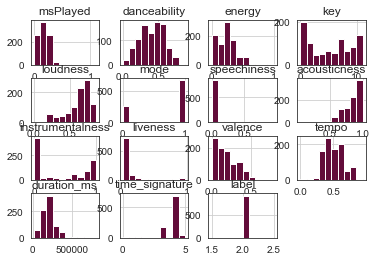

In [439]:
dataset_detailed_df[dataset_detailed_df['label']==2].hist()

In [441]:
dataset_detailed_df.to_excel('final_clusters.xlsx')
dataset_df.to_excel('kmeans_input.xlsx')